In [2]:
# Importación de librerías necesarias
import pandas as pd  # Librería para manipulación y análisis de datos
import numpy as np  # Librería para operaciones matemáticas de alto nivel
from numpy import asarray
from numpy import zeros
import re  # Librería para trabajar con expresiones regulares
import nltk  # Herramienta de lenguaje natural
from nltk.corpus import stopwords  # Importación de palabras comunes que se pueden ignorar en el análisis de texto
import os  # Librería para interactuar con el sistema operativo

from numpy import array  # Importación específica de la función array de numpy
from keras_preprocessing.sequence import pad_sequences  # Herramienta para ajustar secuencias a la misma longitud
from keras import Sequential  # Modelo secuencial para la construcción de la red neuronal
from keras.layers import (  # Importación de distintas capas para construir una red neuronal
    Activation, Dropout, Dense, 
    Flatten, Conv1D, LSTM, 
    GlobalMaxPooling1D, Embedding
)
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split  # Función para dividir datos en entrenamiento y prueba
from keras.preprocessing.text import Tokenizer  # Herramienta para convertir textos en secuencias de números
from nltk.tokenize import RegexpTokenizer  # Herramienta para tokenización basada en expresiones regulares
from nltk.tokenize.treebank import TreebankWordDetokenizer  # Herramienta para revertir la tokenización (destokenización) a texto normal

import matplotlib.pyplot as plt  # Librería para la generación de gráficos



AttributeError: partially initialized module 'nltk' has no attribute 'internals' (most likely due to a circular import)

##  Paso 1 Lectura del Corpus

In [ ]:
### Juntamos en un csv cada uno de los textos para poder pasar al preprocesamiento

# Ruta al directorio principal que contiene las carpetas de categorías
directorio_principal = './Textos_para_Clasificar'

# Lista para almacenar los datos
datos = []

# Recorre cada carpeta (categoría) en el directorio principal
for categoria in os.listdir(directorio_principal):
    # Construye la ruta completa hacia la carpeta de la categoría actual
    ruta_categoria = os.path.join(directorio_principal, categoria)
    
    # Verifica si la ruta corresponde a un directorio
    if os.path.isdir(ruta_categoria):
        
        # Recorre cada archivo en la carpeta de la categoría
        for archivo in os.listdir(ruta_categoria):
            # Construye la ruta completa hacia el archivo actual
            ruta_archivo = os.path.join(ruta_categoria, archivo)
            
            # Abre y lee el contenido del archivo
            with open(ruta_archivo, 'r', encoding='utf-8') as f:
                texto = f.read()
                # Almacena el texto y la categoría en la lista de datos
                datos.append([texto, categoria])

# Crea un DataFrame con los datos recolectados
df = pd.DataFrame(datos, columns=['Texto', 'Categoría'])
# Guarda el DataFrame como un archivo CSV
df.to_csv('datos_clasificador.csv', index=False)

# Imprime el DataFrame
print(df)


                                                Texto Categoría
0   Los quirópteros (Chiroptera), conocidos comúnm...  Animales
1   Águila es el nombre dado a las mayores aves de...  Animales
2   Los vulpinos (Vulpini) son una tribu de mamífe...  Animales
3   Los elefantes o elefántidos (Elephantidae) son...  Animales
4   Los delfines (Delphinidae), llamados también d...  Animales
5   ﻿Crocodylidae (castellanizado como crocodílido...  Animales
6   Australia, oficialmente Mancomunidad de Austra...   Lugares
7   Japón (Nihon o Nippon), oficialmente Estado de...   Lugares
8   Inglaterra (en inglés, England) es una de las ...   Lugares
9   México (Acerca de este sonido [ˈmexiko]), ofic...   Lugares
10  Canadá (Canada) es un país soberano de América...   Lugares
11  Alemania, oficialmente República Federal de Al...   Lugares
12  Isaac Asimov (RSFS de Rusia, 20 de diciembre d...  Personas
13  ﻿Albert Einstein (Imperio alemán; 14 de marzo ...  Personas
14  Isaac Newton, 25 de diciembre de 164

<BarContainer object of 4 artists>

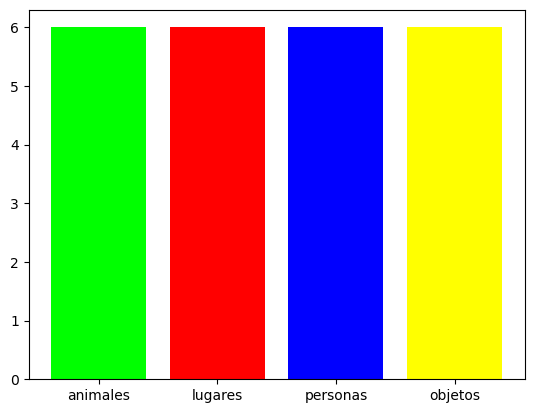

In [ ]:
# Inicialización de contadores para cada categoría
animales = 0
lugares = 0
personas = 0
objetos = 0

# Itera sobre cada entrada en la columna 'Categoría' del DataFrame
for text in df["Categoría"]:
    # Incrementa el contador correspondiente según la categoría
    if(text == 'Animales'):
        animales += 1
    elif(text == 'Lugares'):
        lugares += 1
    elif(text == 'Personas'):
        personas += 1
    elif(text == 'Objetos'):
        objetos += 1

# Crea un gráfico de barras para visualizar la distribución de categorías
plt.bar(
    ['animales', 'lugares', 'personas', 'objetos'],  # Etiquetas del eje X
    [animales, lugares, personas, objetos],  # Valores de las barras
    color = ['lime', 'red', 'blue', 'yellow']  # Colores de las barras
)


### Paso 2: Preprocesamiento

In [ ]:
# Obtención de la lista de stopwords en español
stop_words = set(stopwords.words('spanish'))

# Inicialización de la lista X que almacenará los textos procesados
X = []

# Obtención de la lista de textos desde el DataFrame
textos = list(df['Texto'])
for text in textos:
    
    sentence = text
    # Eliminación de stopwords del texto (reemplazando cada stopword con espacio en blanco)
    for stopword in stop_words:
        sentence = sentence.replace(" " + stopword + " ", " ")

    # Eliminación de espacios múltiples
    sentence = re.sub(r'\s+', ' ', sentence)
    # Conversión del texto a minúsculas
    sentence = sentence.lower()
    # Inicialización del tokenizer que eliminará la puntuación
    tokenizer = RegexpTokenizer(r'\w+')
    # Tokenización del texto (separación en palabras)
    result = tokenizer.tokenize(sentence)
    # "Destokenización" del resultado, uniendo las palabras en un solo texto nuevamente
    X.append(TreebankWordDetokenizer().detokenize(result))
    # Eliminación de acentos en las vocales
    X = [re.sub(r'[á]', 'a', i) for i in X]
    X = [re.sub(r'[é]', 'e', i) for i in X]
    X = [re.sub(r'[í]', 'i', i) for i in X]
    X = [re.sub(r'[ó]', 'o', i) for i in X]
    X = [re.sub(r'[ú]', 'u', i) for i in X]

# Verificación visual del resultado del preprocesamiento, imprimiendo cada texto procesado
for i in range(0, len(X)):
    print(X[i])

# Impresión del número de palabras en cada texto procesado
for i in range(0, len(X)):
    print(len(X[i].split()))


los quiropteros chiroptera conocidos comunmente murcielagos orden mamiferos placentarios cuyas extremidades superiores desarrollaron alas con aproximadamente 1100 especies representan aproximadamente 20 todas especies mamiferos convierte segundo orden numeroso clase tras roedores estan presentes continentes excepto antartida son unicos mamiferos capaces volar extendido casi mundo ocupado gran variedad nichos ecologicos diferentes desempeñan papel ecologico vital polinizadores controladores plagas insectos pequeños vertebrados desarrollan importante papel dispersion semillas muchas plantas tropicales dependen completo murcielagos tienen patas anteriores transformadas alas mitad especies conocidas orientan cazan medio ecolocalizacion cerca 70 especies insectivoras mayor parte resto frugivoras alimentan pequeños vertebrados ranas roedores aves peces murcielagos o caso vampiros subfamilia desmodontinae sangre su tamaño varia 29 33 mm longitud 2 g peso murcielago moscardon craseonycteris th

## Paso 3 - Creación de vectores / matrices de entrada y salida para el entrenamiento

In [ ]:
# Creación del vector objetivo basado en las categorías
Categorias = df['Categoría']  # Obtención de la columna 'Categoría' del DataFrame

y = []  # Inicialización del vector objetivo
for categoria in Categorias:
    # Asignación de un valor numérico a cada categoría y agregación al vector objetivo
    if categoria == "Animales":
        y.append(0)
    elif categoria == "Lugares":
        y.append(1)
    elif categoria == "Personas":
        y.append(2)
    elif categoria == "Objetos":
        y.append(3)

# Impresión del vector objetivo para verificación
print("Vector de objetivos:")
print(y)


Vector de objetivos:
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3]


In [ ]:
# Separación de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)  # Utiliza un 20% de los datos para el conjunto de prueba

# Inicialización del Tokenizer con un máximo de 1000 palabras/tokens
tokenizer = Tokenizer(num_words=1000)
# Ajusta el tokenizer a los textos del conjunto de entrenamiento
tokenizer.fit_on_texts(X_train)

# Convierte los textos en secuencias de números enteros (índices de tokens)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [ ]:
# Definición de la longitud máxima para las secuencias
maxlen = 150

# Ajuste de la longitud de las secuencias mediante padding
# Si una secuencia es más corta que 'maxlen', se rellena con ceros al final (padding='post')
# Si una secuencia es más larga que 'maxlen', se trunca a 'maxlen'
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Impresión para verificación y muestra del tamaño de la matriz de entrenamiento
print("Matriz de valores para las palabras:")
print(X_train.shape)  # Debe incluir print para mostrar la salida


Matriz de valores para las palabras:


(19, 150)

In [ ]:
# Impresión de los conjuntos de entrenamiento para verificar su coherencia
print(X_train)  # Impresión de la matriz de entrenamiento (textos convertidos a secuencias de números)
print(y_train)  # Impresión del vector objetivo de entrenamiento (categorías convertidas a números)


[[665 213 666 ... 723 724  51]
 [377  53 731 ... 795 796 797]
 [147  94 798 ...   0   0   0]
 ...
 [ 16 606 323 ...   0   0   0]
 [ 78   5  67 ...   0   0   0]
 [338  24 618 ...   0   0   0]]
[1, 0, 3, 3, 0, 1, 3, 1, 2, 1, 0, 0, 0, 3, 2, 2, 0, 1, 2]


## Paso 4: Generación de Embeddings

In [ ]:
# Apertura del archivo de embeddings (Word2Vec en español) en modo lectura
embeddings_dictionary = dict()  # Inicialización del diccionario que almacenará los embeddings
Embeddings_file = open('../Word2Vect_Spanish.txt', encoding="utf8")

# Iteración sobre cada línea del archivo de embeddings
for linea in Embeddings_file:
    caracts = linea.split()  # Separación de la línea en palabras/características
    palabra = caracts[0]  # La primera palabra es el token
    vector = asarray(caracts[1:], dtype='float32')  # El resto de la línea corresponde al vector de embeddings
    embeddings_dictionary[palabra] = vector  # Asignación del vector de embeddings al token correspondiente en el diccionario

# Cierre del archivo de embeddings
Embeddings_file.close()


In [ ]:
# Obtención del tamaño del vocabulario (número de palabras únicas) incrementado en 1 para tener en cuenta el índice 0
vocab_size = len(tokenizer.word_index) + 1

# Inicialización de la matriz de embeddings con dimensiones (tamaño del vocabulario x 300)
embedding_matrix = zeros((vocab_size, 300))
# Iteración sobre cada palabra y su índice en el vocabulario del tokenizer
for word, index in tokenizer.word_index.items():
    # Obtención del vector de embeddings de la palabra actual desde el diccionario de embeddings
    embedding_vector = embeddings_dictionary.get(word)
    # Si la palabra existe en el diccionario de embeddings, se inserta su vector de embeddings en la matriz
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


## Paso 5: Aplicación del Modelo DNN

In [ ]:
# Inicialización del modelo secuencial (las capas se añadirán en el orden en que se enumeran)
model = Sequential()

# Creación de la capa de embeddings con los siguientes parámetros:
# - Tamaño del vocabulario: número total de palabras únicas en los datos
# - Dimensiones del embedding: tamaño del vector de embeddings (300 en este caso, para coincidir con los embeddings pre-entrenados)
# - Matriz de pesos: matriz de embeddings pre-entrenados
# - Longitud de entrada: longitud máxima de las secuencias de entrada
# - Entrenable: indica si los pesos de la capa se actualizarán durante el entrenamiento (False significa que no se actualizarán)
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)

# Añadiendo las capas al modelo secuencial:
# - Capa de embeddings: convertirá cada número entero en un vector de embeddings
# - Capa Flatten: aplanará la salida de la capa de embeddings para que pueda ser utilizada por la capa Dense
# - Capa Dense: capa de neuronas completamente conectadas con 4 neuronas (una para cada categoría) y activación sigmoidal
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(4, activation='sigmoid'))  # Cambiada a 4 neuronas en lugar de 1, para manejar 4 categorías

# Compilación del modelo con los siguientes parámetros:
# - Optimizador: algoritmo de optimización Adam
# - Función de pérdida: entropía cruzada categórica (apropiada para clasificación multiclase)
# - Métricas: precisión (fracción de imágenes correctamente clasificadas)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Impresión del resumen del modelo para verificar la configuración
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 300)          628800    
                                                                 
 flatten_3 (Flatten)         (None, 45000)             0         
                                                                 
 dense_3 (Dense)             (None, 4)                 180004    
                                                                 
Total params: 808,804
Trainable params: 180,004
Non-trainable params: 628,800
_________________________________________________________________
None


In [ ]:
# Conversión de las listas a arreglos de NumPy para un manejo más eficiente
y_train_np = np.array(y_train)
X_train_np = np.array(X_train)
y_test_np = np.array(y_test)
X_test_np = np.array(X_test)

# Codificación one-hot de las etiquetas de salida (y_train y y_test)
# Convertimos cada etiqueta categórica en un vector binario
y_train_onehot = to_categorical(y_train_np, num_classes=4)
y_test_onehot = to_categorical(y_test_np, num_classes=4)

# Entrenamiento del modelo utilizando el método fit
# Se proporcionan los datos de entrenamiento, tamaño del batch, número de épocas y porcentaje de datos para validación
history = model.fit(X_train_np, y_train_onehot, batch_size=10, epochs=30, verbose=3, validation_split=0.2)

# Evaluación del modelo en el conjunto de prueba
# Se obtienen la pérdida y precisión del modelo
score = model.evaluate(X_test_np, y_test_onehot, verbose=3)

# Impresión de la pérdida y precisión del modelo en el conjunto de prueba
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Test Loss: 1.2257025241851807
Test Accuracy: 0.6000000238418579


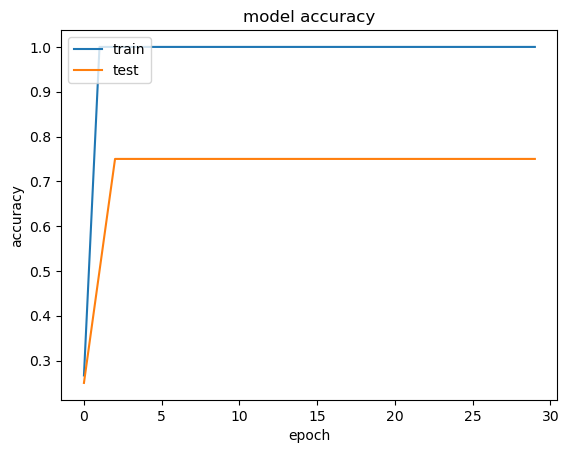

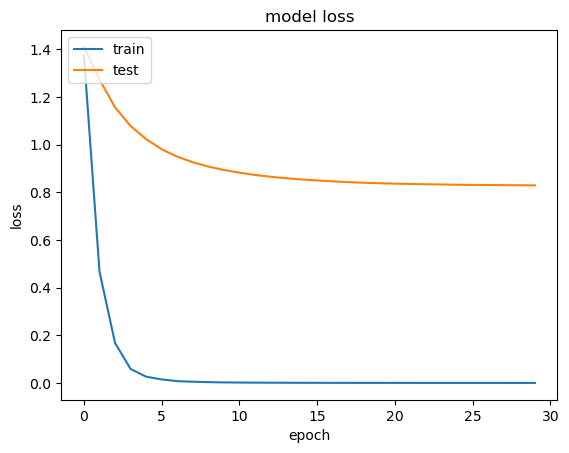

In [ ]:
# Gráfico de la precisión del modelo durante el entrenamiento
plt.plot(history.history['acc'])  # Precisión en el conjunto de entrenamiento
plt.plot(history.history['val_acc'])  # Precisión en el conjunto de validación

# Título y etiquetas del gráfico
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
# Leyenda ubicada en la esquina superior izquierda
plt.legend(['Entrenamiento','Validación'], loc='upper left')
# Mostrar el gráfico
plt.show()

# Gráfico de la pérdida del modelo durante el entrenamiento
plt.plot(history.history['loss'])  # Pérdida en el conjunto de entrenamiento
plt.plot(history.history['val_loss'])  # Pérdida en el conjunto de validación

# Título y etiquetas del gráfico
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
# Leyenda ubicada en la esquina superior izquierda
plt.legend(['Entrenamiento','Validación'], loc='upper left')
# Mostrar el gráfico
plt.show()
